In [1]:
import os
import sys
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
import numpy as np
import pandas as pd
import datetime
import pytz
import joblib
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from datetime import date
import holidays

In [2]:
# Auto-reload to directly apply changes 
%load_ext autoreload
%autoreload 2

# Display all columns
pd.set_option("display.max_columns", None)

# Import data



In [3]:
WORKDIR = os.getcwd()
DATADIR = os.path.join(WORKDIR, 'data')

In [54]:
# Load data
from pyprojroot import here
df = ( 
        pd.read_csv(f"{DATADIR}/load_actuals.csv")
          .set_index("data_index_")
)
# Set timezone
df.index = pd.to_datetime(df.index).tz_convert("Europe/Amsterdam")

# Check for gaps in time series

In [5]:
min_time = min(df.index)
max_time = max(df.index)

In [55]:
dt_idx = pd.date_range(min_time, max_time, freq='H')
dt_idx

DatetimeIndex(['2020-01-01 01:00:00+01:00', '2020-01-01 02:00:00+01:00',
               '2020-01-01 03:00:00+01:00', '2020-01-01 04:00:00+01:00',
               '2020-01-01 05:00:00+01:00', '2020-01-01 06:00:00+01:00',
               '2020-01-01 07:00:00+01:00', '2020-01-01 08:00:00+01:00',
               '2020-01-01 09:00:00+01:00', '2020-01-01 10:00:00+01:00',
               ...
               '2021-06-09 17:00:00+02:00', '2021-06-09 18:00:00+02:00',
               '2021-06-09 19:00:00+02:00', '2021-06-09 20:00:00+02:00',
               '2021-06-09 21:00:00+02:00', '2021-06-09 22:00:00+02:00',
               '2021-06-09 23:00:00+02:00', '2021-06-10 00:00:00+02:00',
               '2021-06-10 01:00:00+02:00', '2021-06-10 02:00:00+02:00'],
              dtype='datetime64[ns, Europe/Amsterdam]', length=12625, freq='H')

In [56]:
df = df.reindex(dt_idx, fill_value='missing').rename_axis("data_index_")

In [8]:

df[df.isnull().all(axis=1)]

Empty DataFrame
Columns: [load_actuals_mw]
Index: []

In [9]:
df.isnull().sum()

load_actuals_mw    0
dtype: int64

# Data exploration

In [10]:
# Visualise results
def plot_figure_load(df):
    fig = go.Figure(
        make_subplots(
            shared_xaxes=True, vertical_spacing=0.02,
        )
    )
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df["load_actuals_mw"],
            name="Actual",
            legendgroup="Actual",
            showlegend=True,
            line_color="green",
            opacity=0.5,
        ))
    title_text = "Energy demand"
    fig.update_layout(title={'text': title_text,
                             'y': 0.95,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      autosize=False,
                      width=800,
                      height=800,
                      paper_bgcolor='white',
                      plot_bgcolor='white'
                      )

    fig.update_yaxes(title_text="Demand [MW]", title_standoff=30, title_font=dict(size=12),
                     showgrid=True, gridcolor='lightgrey',
                     zeroline=True, zerolinecolor='lightgrey',
                     )
    fig.update_xaxes(title_text="Date",
                     showgrid=True, gridcolor='lightgrey',
                     zeroline=True, zerolinecolor='lightgrey',
                     )

    return fig

In [11]:
fig = plot_figure_load(df)
fig.show()

# Deal with outliers

<AxesSubplot:xlabel='data_index_'>

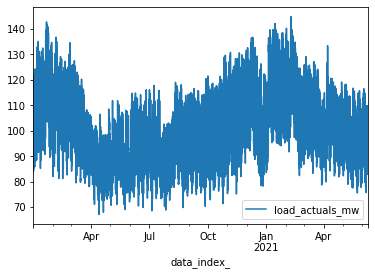

In [12]:
#deal with outliers

df = df.assign(
    load_actuals_mw = lambda df: df.load_actuals_mw.replace([df.load_actuals_mw.min()], df.load_actuals_mw.median())
)
df.plot()

# 1. Batch model

## 1A. Baseline model

Because demand has a strong daily and weekly pattern, the baseline model is a seasonal naive forecats. The predicted demand is the demand at the same time of the day 1 week ago.

In [13]:
# Baseline model: Shifted by 1 week
df_load_baseline = df.copy(deep=True).reset_index()[["load_actuals_mw"]]

df_load_baseline["data_index_"] = pd.to_datetime(
  df.reset_index()["data_index_"]
) + datetime.timedelta(weeks=1)

df_load_baseline = df_load_baseline.set_index("data_index_").rename(
    columns={"load_actuals_mw": "baseline"}
)

<AxesSubplot:xlabel='data_index_'>

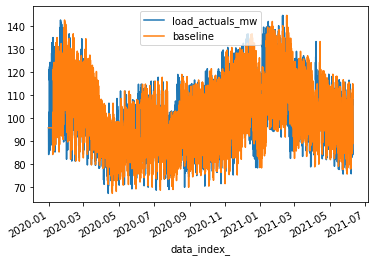

In [14]:
baseline_predict =pd.merge(df,df_load_baseline,how='left',left_on=['data_index_'],right_on=['data_index_']).fillna(method="bfill")
baseline_predict.plot()

In [15]:
# Plot next to each other
fig = plot_figure_load(df)

# Plot baseline prediction
fig.add_trace(
    go.Scatter(
        x=df_load_baseline.index,
        y=df_load_baseline["baseline"],
        name="Baseline model",
        legendgroup="Baseline model",
        showlegend=True,
        line_color="orange",
        opacity=0.5,
    ),
    col=1,
    row=1,
)

# Feature engineering 

In [16]:
df =df.assign(hour =  lambda df: df.index.hour,
              quarter_of_day = lambda df: pd.cut(df.hour, bins=4, labels=False) +1 ,
              date =df.index,
              day_of_week = lambda df: df.date.dt.weekday,
              )

In [17]:
sw_holidays = holidays.Netherlands()

df['is_holiday'] = [
    1 if str(val).split()[0] in  sw_holidays else 0 for val in df.index
                   ]

In [18]:
temperature = ( pd.read_csv(f"{DATADIR}/weather.csv")
                  .set_index("data_index_")

)
# Set timezone
temperature.index = pd.to_datetime(temperature.index).tz_convert("Europe/Amsterdam")
temperature = temperature.reindex(dt_idx).rename_axis("data_index_")

In [19]:
#check Temperature data for nulls
temperature.isnull().sum()

temperature    0
solar_ghi      0
dtype: int64

In [20]:
df =pd.merge(df,temperature,how='left',left_on=['data_index_'],right_on=['data_index_'])

<AxesSubplot:xlabel='data_index_'>

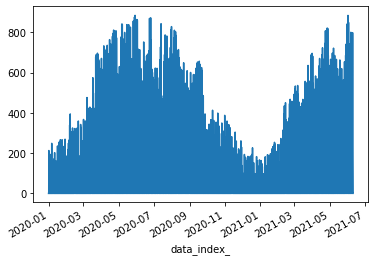

In [21]:
df.solar_ghi.plot()

<AxesSubplot:xlabel='data_index_'>

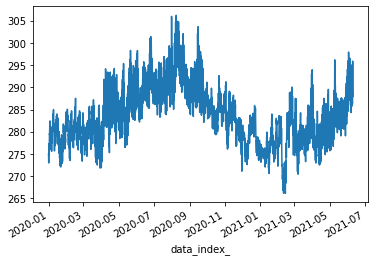

In [22]:
df.temperature.plot()

## 1B. ML model

In [23]:
# add lagged features
def generate_lagged_features(df, var, max_lag):
    for t in range(1, max_lag+1):
        df[var+'_lag'+str(t)] = df[var].shift(t, freq='1H')

generate_lagged_features(df, 'load_actuals_mw', 6)
# generate_lagged_features(df, 'demand', 6)        

In [24]:
#fill na values
df =df.fillna(method="bfill")
df

load_actuals_mw  hour  quarter_of_day  \
data_index_                                                        
2020-01-01 01:00:00+01:00        95.756328     1               1   
2020-01-01 02:00:00+01:00        91.506670     2               1   
2020-01-01 03:00:00+01:00        87.394102     3               1   
2020-01-01 04:00:00+01:00        84.923467     4               1   
2020-01-01 05:00:00+01:00        84.112076     5               1   
...                                    ...   ...             ...   
2021-06-09 22:00:00+02:00       102.034949    22               4   
2021-06-09 23:00:00+02:00        99.569507    23               4   
2021-06-10 00:00:00+02:00        94.768896     0               1   
2021-06-10 01:00:00+02:00        90.339627     1               1   
2021-06-10 02:00:00+02:00        84.122788     2               1   

                                               date  day_of_week  is_holiday  \
data_index_                                                                    
2020-01-01 01:00:00+01:00 2020-01-01 01:00:00+01:00            2           1   
2020-01-01 02:00:00+01:00 2020-01-01 02:00:00+01:00            2           1   
2020-01-01 03:00:00+01:00 2020-01-01 03:00:00+01:00            2           1   
2020-01-01 04:00:00+01:00 2020-01-01 04:00:00+01:00            2           1   
2020-01-01 05:00:00+01:00 2020-01-01 05:00:00+01:00            2           1   
...                                             ...          ...         ...   
2021-06-09 22:00:00+02:00 2021-06-09 22:00:00+02:00            2           0   
2021-06-09 23:00:00+02:00 2021-06-09 23:00:00+02:00            2           0   
2021-06-10 00:00:00+02:00 2021-06-10 00:00:00+02:00            3           0   
2021-06-10 01:00:00+02:00 2021-06-10 01:00:00+02:00            3           0   
2021-06-10 02:00:00+02:00 2021-06-10 02:00:00+02:00            3           0   

                           temperature  solar_ghi  load_actuals_mw_lag1  \
data_index_                                                               
2020-01-01 01:00:00+01:00   274.989655   0.000000             95.756328   
2020-01-01 02:00:00+01:00   274.423157   0.000000             95.756328   
2020-01-01 03:00:00+01:00   274.266571   0.000000             91.506670   
2020-01-01 04:00:00+01:00   274.130737   0.000000             87.394102   
2020-01-01 05:00:00+01:00   273.969421   0.000000             84.923467   
...                                ...        ...                   ...   
2021-06-09 22:00:00+02:00   290.521515   0.000251            102.845906   
2021-06-09 23:00:00+02:00   289.597931   0.000000            102.034949   
2021-06-10 00:00:00+02:00   288.980194   0.000000             99.569507   
2021-06-10 01:00:00+02:00   288.254852   0.000000             94.768896   
2021-06-10 02:00:00+02:00   287.930267   0.000000             90.339627   

                           load_actuals_mw_lag2  load_actuals_mw_lag3  \
data_index_                                                             
2020-01-01 01:00:00+01:00             95.756328             95.756328   
2020-01-01 02:00:00+01:00             95.756328             95.756328   
2020-01-01 03:00:00+01:00             95.756328             95.756328   
2020-01-01 04:00:00+01:00             91.506670             95.756328   
2020-01-01 05:00:00+01:00             87.394102             91.506670   
...                                         ...                   ...   
2021-06-09 22:00:00+02:00            104.175466            107.161133   
2021-06-09 23:00:00+02:00            102.845906            104.175466   
2021-06-10 00:00:00+02:00            102.034949            102.845906   
2021-06-10 01:00:00+02:00             99.569507            102.034949   
2021-06-10 02:00:00+02:00             94.768896             99.569507   

                           load_actuals_mw_lag4  load_actuals_mw_lag5  \
data_index_                                                             
2020-01-01 01:00:00+01:00    

In [25]:
def add_fourier_features(df, column_name, period, n, period_name = "f"):
    t = df[column_name]
    for i in range(n):
        j = math.ceil((i+1)/2)
        if i%2:
            df[f'{period_name}_{i}'] = np.cos(j * 2 * np.pi * t / period)
        else:
            df[f'{period_name}_{i}'] = np.sin(j * 2 * np.pi * t / period)
    return df

def create_workday_weekend_features(df, fourier_order):
    # split features in workday / weekend
    df['is_workday'] = (~(df.is_holiday.astype(bool) | (df.day_of_week == 5) | (df.day_of_week == 6)))
    workday_data = {
        f'workday_{k}':df[k]*df.is_workday.astype(int)
        for k
        in ['temperature', 'solar_ghi'] + [f'f_quarter_{f}' for f in range(fourier_order)]
    }
    weekend_data = {
        f'weekend_{k}':df[k]*(~df.is_workday).astype(int)
        for k
        in ['temperature', 'solar_ghi'] + [f'f_quarter_{f}' for f in range(fourier_order)]
    }
    return workday_data, weekend_data

# add Fourier features to capture daily pattern in model
fourier_order = 6

df = add_fourier_features(df, column_name ="quarter_of_day", period= 4 * 24, n=fourier_order, period_name="f_quarter")

# split workdays and weekend/holidays
workday_data, weekend_data = create_workday_weekend_features(df, fourier_order)
df_linregr = pd.DataFrame(
    {**workday_data, **weekend_data, "load": df["load_actuals_mw"]}
)

df_linregr = pd.merge(df_linregr,df.filter(like='lag'),how='left',left_on=['data_index_'],right_on=['data_index_'])
# df_linregr =pd.merge(df_linregr, wind_solar_predictions ,how='left',left_on=['data_index_'],right_on=['data_index_'])
# List the input feature columns
feat_columns = list(workday_data.keys()) + list(weekend_data.keys())+df.filter(like='lag').columns.to_list()#+['solar_prediction_mw', 'wind_prediction_mw']

In [26]:
df_linregr.reset_index().to_csv(f"{DATADIR}/load_data_processed.csv", index=False)

In [27]:
df_linregr.columns.tolist()

['workday_temperature',
 'workday_solar_ghi',
 'workday_f_quarter_0',
 'workday_f_quarter_1',
 'workday_f_quarter_2',
 'workday_f_quarter_3',
 'workday_f_quarter_4',
 'workday_f_quarter_5',
 'weekend_temperature',
 'weekend_solar_ghi',
 'weekend_f_quarter_0',
 'weekend_f_quarter_1',
 'weekend_f_quarter_2',
 'weekend_f_quarter_3',
 'weekend_f_quarter_4',
 'weekend_f_quarter_5',
 'load',
 'load_actuals_mw_lag1',
 'load_actuals_mw_lag2',
 'load_actuals_mw_lag3',
 'load_actuals_mw_lag4',
 'load_actuals_mw_lag5',
 'load_actuals_mw_lag6']

In [28]:
from sklearn.metrics import mean_absolute_percentage_error

In [29]:
# Define size of train and test set of model
number_of_training_days = 30
number_of_test_days = 30

test_start_date_run_i = df_linregr.index.min() + datetime.timedelta(
    days=number_of_training_days
)
test_end_date = df_linregr.index.max()
df_result = pd.DataFrame()

# Run model for full period of data set
while True:
    print(f"Start of prediction of this run: {test_start_date_run_i}")

    # split train/test set
    df_train = df_linregr[
        test_start_date_run_i
        - datetime.timedelta(days=number_of_training_days) : test_start_date_run_i
    ]

    df_test = df_linregr[
        test_start_date_run_i : test_start_date_run_i
        + datetime.timedelta(days=number_of_test_days)
    ]

    lr = LinearRegression()
    lr.fit(df_train[feat_columns], df_train["load"])
    
    y_pred = lr.predict(df_test[feat_columns])
    
    # Combine results
    df_result_run_i = pd.DataFrame(
        {
            "load": df_test["load"],
            "pred": y_pred,
        }
    )

    # Store results in a single dataframe
    df_result = df_result.append(df_result_run_i)
    print(f'{mean_absolute_percentage_error(df_result.load, df_result.pred)}')

    # Adjust start date of test set for next run
    test_start_date_run_i = test_start_date_run_i + datetime.timedelta(
        days=number_of_test_days
    )
    if test_start_date_run_i > test_end_date:
        break 


Start of prediction of this run: 2020-01-31 01:00:00+01:00
0.019732871805886624
Start of prediction of this run: 2020-03-01 01:00:00+01:00
0.027354213475081744
Start of prediction of this run: 2020-03-31 02:00:00+02:00
0.026369971047018315
Start of prediction of this run: 2020-04-30 02:00:00+02:00
0.024382836933543164
Start of prediction of this run: 2020-05-30 02:00:00+02:00
0.02319243844910431
Start of prediction of this run: 2020-06-29 02:00:00+02:00
0.022785204252292288
Start of prediction of this run: 2020-07-29 02:00:00+02:00
0.022092542593426853
Start of prediction of this run: 2020-08-28 02:00:00+02:00
0.02165345270812975
Start of prediction of this run: 2020-09-27 02:00:00+02:00
0.021833401373526556
Start of prediction of this run: 2020-10-27 01:00:00+01:00
0.02196135957292892
Start of prediction of this run: 2020-11-26 01:00:00+01:00
0.02172658873185256
Start of prediction of this run: 2020-12-26 01:00:00+01:00
0.021458495759899703
Start of prediction of this run: 2021-01-25 

In [33]:
##MAPE of Linear Regression
mean_absolute_percentage_error(df_result.load, df_result.pred)

0.02088661778878134

In [39]:
compare_baseline =pd.merge(df_result,df_load_baseline,how='left',left_on=['data_index_'],right_on=['data_index_'])
compare_baseline.to_csv(f"{DATADIR}/baseline_predictions.csv", index=True)

In [38]:
#MAPE of baseline model
mean_absolute_percentage_error(compare_baseline.load, compare_baseline.baseline)

0.04678780190534262

In [40]:
wind_solar_predictions = ( pd.read_csv(f"{DATADIR}/wind_solar_predictions.csv")
                  .set_index("data_index_")
)


# Set timezone
wind_solar_predictions.index = pd.to_datetime(wind_solar_predictions.index).tz_convert("Europe/Amsterdam")
wind_solar_predictions = wind_solar_predictions.reindex(dt_idx).rename_axis("data_index_")

In [41]:
prediction_loads =pd.merge(df_result, wind_solar_predictions ,how='left',left_on=['data_index_'],right_on=['data_index_'])

In [42]:
prediction_loads.resample('D').mean().to_csv(f"{DATADIR}/mean_daily_predictions.csv", index=True)

<AxesSubplot:xlabel='data_index_'>

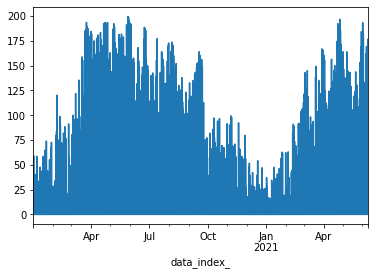

In [43]:

wind_solar_predictions.solar_prediction_mw.plot()


<AxesSubplot:xlabel='data_index_'>

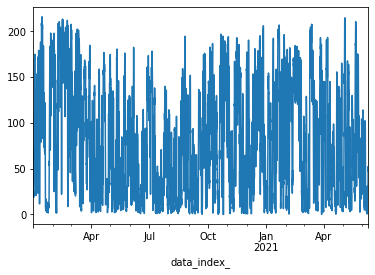

In [44]:
wind_solar_predictions.wind_prediction_mw.plot()

In [45]:
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size = 720, test_size = 720, n_splits=3)
regr = LinearRegression(fit_intercept=True)

regr_cv = RFECV(estimator=regr,
             cv=tscv,
             scoring='neg_mean_absolute_percentage_error',
             verbose=2,
             n_jobs=-1)
regr_cv.fit(df_linregr.drop(columns = ["load"]), y = df_linregr["load"])


RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=720, n_splits=3, test_size=720),
      estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_absolute_percentage_error', verbose=2)

In [46]:

regr_cv.grid_scores_

array([-0.08739882, -0.08217342, -0.07576766, -0.07329569, -0.07060211,
       -0.06831029, -0.06528761, -0.06181883, -0.05978795, -0.05965993,
       -0.05990593, -0.05957986, -0.02209845, -0.02027629, -0.01940084,
       -0.01919482, -0.01840301, -0.01827158, -0.01830349, -0.01829505,
       -0.01818853, -0.0181859 ])

In [47]:
regr_cv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [48]:
supported_features = pd.DataFrame.from_dict(
    {'feature':df_linregr.drop(columns = ["load"]).columns.tolist(), 
     'supported':regr_cv.support_}
)
supported_features

feature  supported
0    workday_temperature       True
1      workday_solar_ghi       True
2    workday_f_quarter_0       True
3    workday_f_quarter_1       True
4    workday_f_quarter_2       True
5    workday_f_quarter_3       True
6    workday_f_quarter_4       True
7    workday_f_quarter_5       True
8    weekend_temperature       True
9      weekend_solar_ghi       True
10   weekend_f_quarter_0       True
11   weekend_f_quarter_1       True
12   weekend_f_quarter_2       True
13   weekend_f_quarter_3       True
14   weekend_f_quarter_4       True
15   weekend_f_quarter_5       True
16  load_actuals_mw_lag1       True
17  load_actuals_mw_lag2       True
18  load_actuals_mw_lag3       True
19  load_actuals_mw_lag4       True
20  load_actuals_mw_lag5       True
21  load_actuals_mw_lag6       True

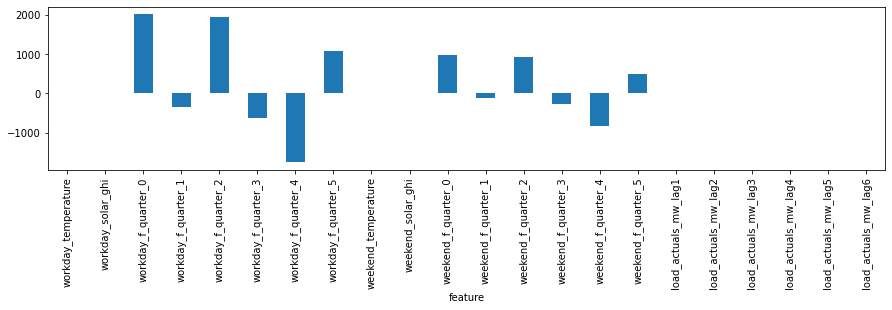

In [50]:
import matplotlib.pyplot as plt

coefs = supported_features.loc[supported_features['supported'], ].copy()
coefs['coefficients'] = regr_cv.estimator_.coef_
coefs.plot.bar('feature', 'coefficients', figsize=(15, 3), legend=False)
plt.show()

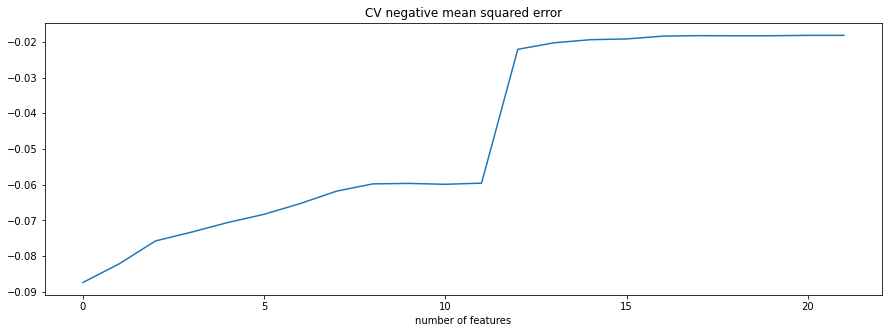

In [51]:
import matplotlib.pyplot as plt

cv_results = pd.DataFrame.from_dict({'cv_score': regr_cv.grid_scores_})
cv_results['mean_absolute_percentage_error'] = cv_results['cv_score']
plt.figure(figsize=(15, 5))
plt.plot(cv_results.index, cv_results['mean_absolute_percentage_error'])
plt.xlabel('number of features')
plt.title('CV negative mean squared error')
plt.show()

In [52]:
cv_results

cv_score  mean_absolute_percentage_error
0  -0.087399                       -0.087399
1  -0.082173                       -0.082173
2  -0.075768                       -0.075768
3  -0.073296                       -0.073296
4  -0.070602                       -0.070602
5  -0.068310                       -0.068310
6  -0.065288                       -0.065288
7  -0.061819                       -0.061819
8  -0.059788                       -0.059788
9  -0.059660                       -0.059660
10 -0.059906                       -0.059906
11 -0.059580                       -0.059580
12 -0.022098                       -0.022098
13 -0.020276                       -0.020276
14 -0.019401                       -0.019401
15 -0.019195                       -0.019195
16 -0.018403                       -0.018403
17 -0.018272                       -0.018272
18 -0.018303                       -0.018303
19 -0.018295                       -0.018295
20 -0.018189                       -0.018189
21 -0.018186                       -0.018186

In [53]:
# Plot next to each other
fig = plot_figure_load(df)

# Plot baseline prediction
fig.add_trace(
    go.Scatter(
        x=df_result.index,
        y=df_result["pred"],
        name="Linear regression model",
        legendgroup="Linear regression model",
        showlegend=True,
        line_color="magenta",
        opacity=0.5,
    ),
    col=1,
    row=1,
)

# 2. Real time model

Deploying your model real-time will beat even advanced ML batch models in performance. Therefore the model is kept simple.

In [ ]:
# Baseline model: Shifted by 15 minutes
df_load_rt = df.copy(deep=True).reset_index()[["load_actuals_mw"]]
df_load_rt["data_index_"] = pd.to_datetime(
    df.reset_index()["data_index_"]
) + datetime.timedelta(minutes=15)
df_load_rt = df_load_rt.set_index("data_index_").rename(
    columns={"load_actuals_mw": "baseline"}
)

In [ ]:
# Plot next to each other
fig = plot_figure_load(df)

# Plot baseline prediction
fig.add_trace(
    go.Scatter(
        x=df_load_rt.index,
        y=df_load_rt["baseline"],
        name="Baseline model",
        legendgroup="Baseline model",
        showlegend=True,
        line_color="orange",
        opacity=0.5,
    ),
    col=1,
    row=1,
)

# Register  processed dataset

In [ ]:
from azureml.core import Workspace, Dataset
ws = Workspace.from_config()


In [ ]:
datastore = ws.get_default_datastore()

In [ ]:
datastore.upload(src_dir='data', target_path='capstone_data', overwrite=True)

In [ ]:
processed_dataset = Dataset.Tabular.from_delimited_files(datastore.path('capstone_data/load_data_processed.csv'))

In [ ]:
processed_ds = processed_dataset.register(workspace=ws, name="capstone_data_processed", description="processed capstone energy data", create_new_version=True)